'''
Copyright 2022 Andrea Rafanelli.
Licensed under the Apache License, Version 2.0 (the "License"); 
you may not use this file except in compliance with the License. 
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on 
an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. 
See the License for the specific language governing permissions and limitations under the License
'''

__author__ = 'Andrea Rafanelli'

In [1]:
import os
import cv2
import torch
from torch.optim import SGD
from torch.utils.data import DataLoader
import segmentation_models_pytorch as sm
import catalyst
import wandb
import random
import albumentations
from sklearn.model_selection import train_test_split
import numpy as np
from collections import defaultdict
import copy
import time
from tqdm.auto import tqdm
import torch.nn.functional as F
import sklearn
import pickle
import pandas as pd

from utils.network import Dataset, diceLoss, lossCalculation, Metrics, training, validating

In [2]:
floodDir = "Data/FloodNet/Train/Labeled/Flooded"
nonFloodDir = "Data/FloodNet/Train/Labeled/Non-Flooded"

floodImgDir = os.path.join(floodDir, "image")
floodMaskDir = os.path.join(floodDir, "mask")
nonFloodImgDir = os.path.join(nonFloodDir, "image")
nonFloodMaskDir = os.path.join(nonFloodDir, "mask")

floodImg = len(os.listdir(floodImgDir))
floodMask = len(os.listdir(floodMaskDir))
nonFloodImg = len(os.listdir(nonFloodImgDir))
nonFloodMask = len(os.listdir(nonFloodMaskDir))
print(f"Flooded images:      {floodImg} Flooded masks:     {floodMask}")
print(f"Non-Flooded images: {nonFloodImg} Non-Flooded masks: {nonFloodMask}")

Flooded images:      204 Flooded masks:     204
Non-Flooded images: 1388 Non-Flooded masks: 1388


In [3]:
labels = {'Background':0,'Building':1,'Road':2, 'Water': 3,'Tree':4,'Vehicle':5,'Pool':6,'Grass':7}

imgDim = 224

In [4]:
x_train = pd.read_pickle('trainIdxNF.pkl')
x_test = pd.read_pickle('testIdxNF.pkl')
x_validation = pd.read_pickle('valIdxNF.pkl')

In [5]:
trainTransformation = albumentations.Compose([ albumentations.Resize(imgDim, imgDim),
                                               albumentations.OneOf([
                                               albumentations.RandomBrightnessContrast( 
                                               brightness_limit = 0.3, contrast_limit = 0.4, p = 1),
                                               albumentations.CLAHE(p = 1),
                                               albumentations.HueSaturationValue(p = 1)], p = 0.9,),
                                               albumentations.IAAAdditiveGaussianNoise(p = 0.2)
                                              ])
preprocessing = albumentations.Compose([albumentations.Normalize(mean = [0.485, 0.456, 0.406], 
                                                                 std = [0.229, 0.224, 0.225])])

testTransformation = albumentations.Compose([albumentations.Resize(imgDim, imgDim)])

In [6]:
train_dataset = Dataset(
    x_train, 
    augmentation = trainTransformation, 
    preprocessing = preprocessing,
    label = labels,
)

test_dataset = Dataset(
    x_test, 
    augmentation = testTransformation, 
    preprocessing = preprocessing,
    label = labels,
)

validation_dataset = Dataset(
    x_validation, validation = True,
    augmentation = testTransformation, 
    preprocessing = preprocessing,
    label = labels,
)


In [9]:
next(iter(validation_dataset))

(0,
 tensor([[[-0.9363, -0.8678, -0.9020,  ..., -0.8849, -0.5082, -0.6623],
          [-0.9020, -0.9534, -1.0048,  ..., -1.0048, -0.9020, -0.9020],
          [-0.9020, -0.8164, -0.9877,  ..., -1.2103, -1.0048, -0.2684],
          ...,
          [-0.3883, -0.3883, -0.7993,  ..., -0.7137, -0.7822, -1.2617],
          [-0.4911, -0.4739, -0.4054,  ..., -0.3027, -0.6452, -1.4672],
          [-0.5253, -0.5082, -0.5424,  ..., -0.8507, -1.2274, -1.3815]],
 
         [[-0.6702, -0.5826, -0.6877,  ...,  0.1702,  0.6429,  0.3803],
          [-0.6352, -0.7052, -0.7052,  ..., -0.1099,  0.1527,  0.0476],
          [-0.6001, -0.4951, -0.6877,  ..., -0.3375, -0.1275,  0.8004],
          ...,
          [-0.3550, -0.3375, -0.6527,  ...,  0.0301,  0.1702, -0.4601],
          [-0.5651, -0.4776, -0.3901,  ...,  0.3803,  0.1352, -0.6527],
          [-0.5476, -0.4776, -0.4426,  ..., -0.0574, -0.4951, -0.5126]],
 
         [[-0.2184, -0.1835, -0.2707,  ..., -0.0092,  0.5136,  0.2522],
          [-0.2532, -0.2

In [7]:
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encoder = 'resnet101'
weights = 'imagenet'
num_epochs = 300
learning_rate = 1e-1
momentum = 0.9
best_loss = 1e10
best_epoch = 0
best_miou = 0
###################################################

model = sm.PSPNet(
    encoder_name = encoder, 
    encoder_weights = weights, 
    classes = len(labels),)

model = model.to(device)


optimizer = torch.optim.SGD([
    {'params': model.decoder.parameters(), 'lr': learning_rate, 'momentum': momentum}, 
    {'params': model.encoder.parameters(), 'lr': 1e-2, 'momentum': momentum},
    {'params': model.segmentation_head.parameters(), 'lr': learning_rate, 'momentum':momentum},
])

In [9]:
wandb.login()

wandb: Currently logged in as: ands. Use `wandb login --relogin` to force relogin


True

In [10]:
wandb.init(project = 'FloodNet')

In [ ]:
for epoch in range(num_epochs):
    
    print('*' * 40)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('*' * 40)
    since = time.time()

    train_loss, train_miou = training(model, lossCalculation, train_loader, optimizer, device, 'Train')
    test_loss, test_miou = validating(model, lossCalculation, test_loader, optimizer, device, 'Test')
    wandb.log({'Train Loss': train_loss, 'Train Miou' : train_miou,
               'Test Loss': test_loss, 'Test Miou' : test_miou})

    if test_miou > best_miou:
        best_miou = test_miou
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Best miou: {best_miou:.4f} Epoch: {epoch +1}')
        print(">>>>> Saving model..")
        torch.save(best_model_wts, "models/best_modelDL2.pt")
                           
        
    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [11]:
model.load_state_dict(torch.load('models/best_modelDL2.pt'))

<All keys matched successfully>

In [12]:
all_masks=[x.replace(".jpg", ".png") for x in x_validation]
mask_paths=[os.path.join('predictionsTrain/', file) for file in all_masks]

In [13]:
validation_loader = DataLoader(validation_dataset, batch_size = 8, shuffle = False)

In [14]:
next(iter(validation_loader))

[tensor([0, 1, 2, 3, 4, 5, 6, 7]),
 tensor([[[[-0.9363, -0.8678, -0.9020,  ..., -0.8849, -0.5082, -0.6623],
           [-0.9020, -0.9534, -1.0048,  ..., -1.0048, -0.9020, -0.9020],
           [-0.9020, -0.8164, -0.9877,  ..., -1.2103, -1.0048, -0.2684],
           ...,
           [-0.3883, -0.3883, -0.7993,  ..., -0.7137, -0.7822, -1.2617],
           [-0.4911, -0.4739, -0.4054,  ..., -0.3027, -0.6452, -1.4672],
           [-0.5253, -0.5082, -0.5424,  ..., -0.8507, -1.2274, -1.3815]],
 
          [[-0.6702, -0.5826, -0.6877,  ...,  0.1702,  0.6429,  0.3803],
           [-0.6352, -0.7052, -0.7052,  ..., -0.1099,  0.1527,  0.0476],
           [-0.6001, -0.4951, -0.6877,  ..., -0.3375, -0.1275,  0.8004],
           ...,
           [-0.3550, -0.3375, -0.6527,  ...,  0.0301,  0.1702, -0.4601],
           [-0.5651, -0.4776, -0.3901,  ...,  0.3803,  0.1352, -0.6527],
           [-0.5476, -0.4776, -0.4426,  ..., -0.0574, -0.4951, -0.5126]],
 
          [[-0.2184, -0.1835, -0.2707,  ..., -0.009

In [15]:
torch.cuda.empty_cache()
metrics = defaultdict(float)
epoch_samples = 0
model.eval()

for index, inputs, labels in tqdm(validation_loader):
    inputs, labels = inputs.to("cuda"), labels.to('cuda')
    with torch.no_grad():
        outputs = model(inputs)
        loss = lossCalculation(outputs, labels, metrics)
        epoch_samples += inputs.size(0)
        preds = torch.sigmoid(outputs)
        preds = preds.data.cpu().numpy()
    for i in range(batch_size):
        try:
            f_mask = reverse_transform_mask(preds[i])
            id_ = all_masks[index[i]].split('/')
            cv2.imwrite('predictionsTrain/{0}'.format(id_[-1]) , f_mask)
        except:
            continue
Metrics(metrics, epoch_samples, 'Validation')
epoch_loss = metrics['Loss'] / epoch_samples
epoch_miou = metrics['MIoU'] / epoch_samples

  0%|          | 0/19 [00:00<?, ?it/s]

Validation: Bce: 0.101152, Dice: 0.133538, Loss: 0.117345, MIoU: 0.660058


In [19]:
import matplotlib.pyplot as plt
from utils.masks import make_palette
from PIL import Image

In [17]:
palette = make_palette( 'cyan', 'red', 'gray', 'blue', 'yellow', 'navydark', 'purple','green')

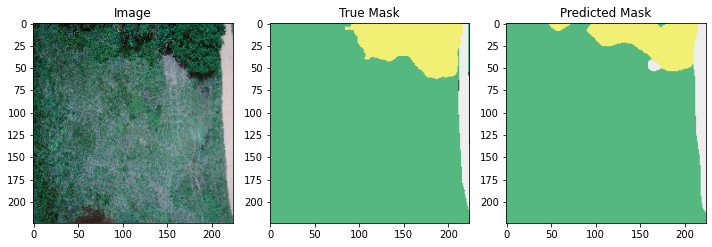

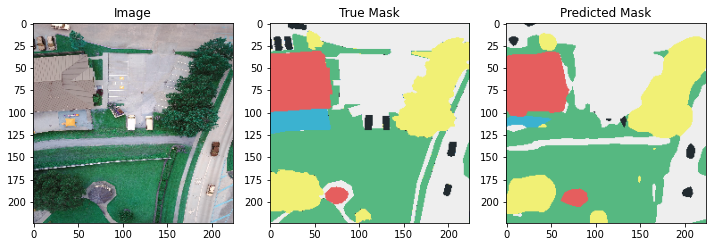

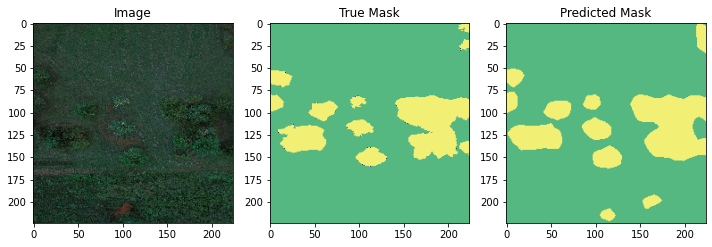

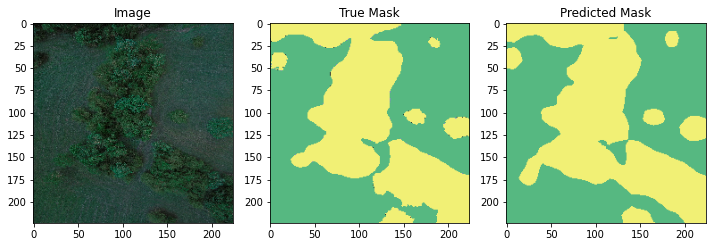

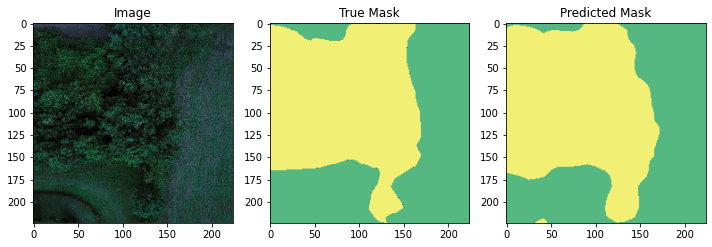

In [20]:
for i in (random.sample(x_validation, 5)):
    
    original = cv2.imread(i)
    original = cv2.resize(original,(imgDim, imgDim))
    
    original_mask = cv2.imread(i.replace("image", "mask").replace(".jpg", "_lab.png"))
    original_mask = cv2.resize(original_mask,(imgDim, imgDim))
    original_mask = cv2.cvtColor(original_mask, cv2.COLOR_BGR2GRAY)
    original_mask = Image.fromarray(original_mask, mode = 'P')
    original_mask.putpalette(palette)

    idx = i.split('/')
    predicted_mask = cv2.imread('predictionsTrain/{0}'.format(idx[-1].replace(".jpg", ".png")))
    predicted_mask = cv2.resize(predicted_mask,(imgDim, imgDim))
    predicted_mask = cv2.cvtColor(predicted_mask, cv2.COLOR_BGR2GRAY)
    predicted_mask = Image.fromarray(predicted_mask, mode = 'P')
    predicted_mask.putpalette(palette)
    
    
    figure, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 10))
    ax[0].imshow(original)
    ax[1].imshow(original_mask)
    ax[2].imshow(predicted_mask)

    ax[0].set_title("Image")
    ax[1].set_title("True Mask")
    ax[2].set_title("Predicted Mask")
   
    figure.tight_layout()
    figure.show()